<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install flax
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bccp nbodykit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [37]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit
from flax import linen as nn
from flax.training import train_state,checkpoints
from nbodykit.lab import cosmology
import matplotlib.pyplot as plt

In [38]:
def npy_loader(path):
    return jnp.load(path)

In [39]:
class SimpleMLP(nn.Module):
    features:Sequence[int]

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
        return x

In [40]:
layer_sizes=[64,256,256,256]
learning_rate=1e-6
model=SimpleMLP(features=layer_sizes)
temp=jnp.ones(2)
params=model.init(jax.random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
restored_state=checkpoints.restore_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks/bestlogcheckpoint_0",target=state)
cosmo=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
z=npy_loader("/content/drive/My Drive/Colab Notebooks/999.npy")[0,:]
a=1/(z+1)

In [78]:
@jit
def predict(params,x,j):
    pred=jnp.exp(restored_state.apply_fn(params,x))
    return pred[j]

In [79]:
@jit
def gradient_at(i,j):
    value1,gradient=jax.value_and_grad(predict,1)(restored_state.params,jnp.array([cosmo[i,0],cosmo[i,2]]),j)
    value2=predict(restored_state.params,jnp.array([cosmo[i,0]+0.00001,cosmo[i,2]]),j)
    value3=predict(restored_state.params,jnp.array([cosmo[i,0],cosmo[i,2]+0.00001]),j)
    return value1,value2,value3,gradient

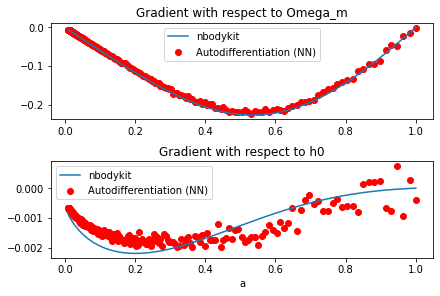

In [80]:
cc=cosmology.Cosmology()
cc.scale_independent_growth_factor(z)
fig,(ax1,ax2)=plt.subplots(2,1,constrained_layout=True)
cosmolh=cc.clone(Omega0_cdm=cosmo[999,0]-cosmo[999,1],Omega_b=cosmo[999,1],h=cosmo[999,2])
cosmolh2=cc.clone(Omega0_cdm=cosmo[999,0]-cosmo[999,1],Omega_b=cosmo[999,1],h=cosmo[999,2]+0.00001)
cosmolh3=cc.clone(Omega0_cdm=cosmo[999,0]+0.00001-cosmo[999,1],Omega_b=cosmo[999,1],h=cosmo[999,2])
g=cosmolh.scale_independent_growth_factor(z)
g2=cosmolh2.scale_independent_growth_factor(z)
g3=cosmolh3.scale_independent_growth_factor(z)
ax1.plot(a,(g3-g)/0.00001)
ax2.plot(a,(g2-g)/0.00001)
for j in range(256):
    value1,value2,value3,gradient=gradient_at(999,j)
    ax1.scatter(a[j],gradient[0],c='r')
    # ax1.scatter(a[j],(value2-value1)/0.00001,c='g')
    ax2.scatter(a[j],gradient[1],c='r')
    # ax2.scatter(a[j],(value3-value1)/0.00001,c='g')
ax1.set_title("Gradient with respect to Omega_m")
ax1.legend(["nbodykit","Autodifferentiation (NN)"])
ax2.set_title("Gradient with respect to h0")
ax2.set_xlabel("a")
ax2.legend(["nbodykit","Autodifferentiation (NN)"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/gradient.png")
drive.flush_and_unmount()